In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import linear_model as lm
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
from stop_words import get_stop_words
import Stemmer
import pymorphy2
from segtok import segmenter
import re
from functools import partial
import pickle
from gensim import corpora, models
from gensim.models import word2vec
import xgboost as xgb 
%matplotlib inline

/home/digitman/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/digitman/anaconda3/lib/python3.5/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.layers.advanced_activations import PReLU
from keras.optimizers import SGD

Using Theano backend.


In [3]:
data1 = pd.read_csv('data/comments_vrn.csv.gz')
data2 = pd.read_csv('data/comments_ekb.csv.gz')
data = pd.concat((data1, data2))

In [4]:
data.shape

(284464, 6)

In [5]:
data.is_gum.value_counts()

1.0    151625
0.0    132839
Name: is_gum, dtype: int64

In [6]:
data.sex = data.sex == 2
data.sex = data.sex.apply(int)

In [7]:
data.head(3)

,from_id,text,is_gum,hour,likes,sex
0,9048238,Вжух даже здесь,0.0,20,1,1
1,9048238,И пишите аккуратнее 😞,0.0,12,3,1
2,9048238,Это #имбрина 😏,0.0,21,0,1


In [8]:
text = ''
for t in data.text.values:
    text += '\n' + t

In [9]:
uniq_text = set(text)

In [10]:
'd' in uniq_text

True

### Length of comments (symbols)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284464 entries, 0 to 98851
Data columns (total 6 columns):
from_id    284464 non-null int64
text       284464 non-null object
is_gum     284464 non-null float64
hour       284464 non-null int64
likes      284464 non-null int64
sex        284464 non-null int64
dtypes: float64(1), int64(4), object(1)
memory usage: 15.2+ MB


In [12]:
lenghts_symb = np.array([len(m) for m in data.text.values])

In [13]:
lenghts_symb.mean(), np.median(lenghts_symb)

(77.168362253220096, 47.0)

In [14]:
min(lenghts_symb), max(lenghts_symb)

(1, 9947)

In [15]:
sum(lenghts_symb)

21951621

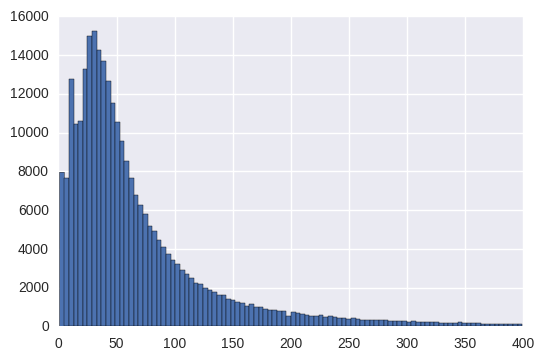

In [16]:
plt.hist(lenghts_symb[lenghts_symb < 400], bins=100);

In [17]:
print('{:.2f}% of comments are shorter than {} symbols'
      .format(lenghts_symb[lenghts_symb < 400].shape[0] / lenghts_symb.shape[0] * 100, 500))

98.36% of comments are shorter than 500 symbols


In [18]:
print('{:.2f}% of comments are longer than {} symbols'
      .format(lenghts_symb[lenghts_symb > 15].shape[0] / lenghts_symb.shape[0] * 100, 15))

87.24% of comments are longer than 15 symbols


### Length of comments (words)

In [19]:
lenghts_word = np.array([len(m.split()) for m in data.text.values])

In [20]:
lenghts_word.mean(), np.median(lenghts_word)

(11.478580769447101, 7.0)

In [21]:
min(lenghts_word), max(lenghts_word)

(0, 1612)

In [22]:
sum(lenghts_word) # total words

3265243

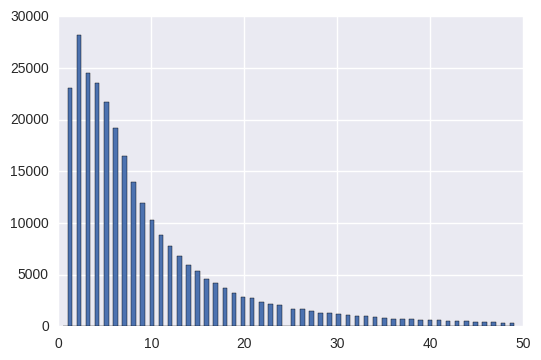

In [23]:
plt.hist(lenghts_word[lenghts_word < 50], bins=100);

In [24]:
print('{:.2f}% of comments are shorter than {} words'
      .format(lenghts_word[lenghts_word < 50].shape[0] / lenghts_word.shape[0] * 100, 50))

97.19% of comments are shorter than 50 words


In [25]:
print('{:.2f}% of comments are longer than {} words'
      .format(lenghts_word[lenghts_word > 4].shape[0] / lenghts_word.shape[0] * 100, 4))

65.08% of comments are longer than 4 words


### Count of unique (words)

In [26]:
words_ = np.array([m.split() for m in data.text.values])

In [27]:
words = []
for w in words_:
    words.extend(w)

In [28]:
len(words)

3265243

In [29]:
len(set(words))

500745

### Links

In [30]:
links = [m for m in data.text.values if 'http' in m or 'www' in m or '.ru' in m or '.com' in m] 

In [31]:
links[:5]

['[id8407059|Евгений], во-первых, по цены. http://market.yandex.ru/search.xml?hid=91709&text=%D1%81%D1%87%D0%B5%D1%82%D1%87%D0%B8%D0%BA%20%D0%B3%D0%B0%D0%B7%D0%B0&srnum=117&ortext=%D1%81%D1%87%D0%B5%D1%82%D1%87%D0%B8%D0%BA%20%D0%B3%D0%B0%D0%B7%D0%B0 во-вторых, даже при отсутствии газонагревательных приборов разница расхода может составлять разы. Моя мать, например, любит газовой плитой кухню отапливать. В-третьих, тебя не смущает то, что электросчетчики ставили и ставят на любых потребителей, будь там хоть сортир с лампочкой? Ты просто не привык к этому, посему - возражаешь. А наличие прибора учета - это правильно. И ставят его, кстати, далеко не на один год. У нас уже лет 10 стоит.',
 '[id212860568|Дмитрий], ну измерь сам. Будешь удивлен http://maps.yandex.ru/?ll=39.211973%2C51.573975&spn=0.184536%2C0.086108&z=13&l=sat%2Cskl',
 '[id10072765|Александр], ты еще дрессировщика дрожжевых бактерий Жданова вспомни. Тоже "авторитет". с тем же успехом я тебе могу ответить этим: http://zenslim.

In [32]:
print('{:.2f}% of comments contain links'.format(len(links) / len(data) * 100))

0.50% of comments contain links


## Preprocessing

### Dropping short and long

In [33]:
comments = data[(lenghts_word < 50) & (lenghts_word > 4)]

In [34]:
comments.shape

(177132, 6)

### Dropping with spam

In [35]:
without_link = [False if 'http' in c or 'www' in c or '.ru' in c or '.com' in c else True for c in comments.text.values] 

In [36]:
comments = comments[without_link]

In [37]:
comments.shape

(176335, 6)

In [38]:
comments_lenghts = np.array([len(m) for m in comments.text.values])

In [39]:
comments_lenghts.argsort()[:10]

array([ 31876,  31809,  31729, 134619,  12582,  63201, 146522, 170450,
        51659,  31418])

In [40]:
comments.text.values[21846]

'[id16867860|Дмитрий], басс должен давить душу 😃'

In [41]:
(comments.from_id.value_counts() > 5).sum()

3288

### Make class balanced

In [42]:
comments_ = comments.copy()

In [42]:
comments_vc = comments_.is_gum.value_counts()
comments_vc

1.0    92485
0.0    83850
Name: is_gum, dtype: int64

In [43]:
delta = comments_vc[1] - comments_vc[0]
delta

8635

In [44]:
index_to_del = np.random.choice(comments_[comments_.is_gum == 1].index, delta, replace=False)
comments_.drop(index_to_del, inplace=True)

In [45]:
comments_.is_gum.value_counts()

1.0    82115
0.0    82041
Name: is_gum, dtype: int64

## Baseline

In [44]:
vectorizer = CountVectorizer(max_features=3000, ngram_range=(1, 3), analyzer='word', min_df=50)
X = vectorizer.fit_transform(comments.text.values)
y = comments.is_gum.values
# y = comments.sex.values

In [45]:
X.shape

(176335, 3000)

In [46]:
lr = lm.LogisticRegression()

In [47]:
np.random.seed(0)

In [48]:
baseline_scores = cross_val_score(lr, X, y, cv=5)
baseline_scores.mean(), baseline_scores.std()

(0.52595911191765676, 0.01168435998948367)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, comments.is_gum, test_size=0.2, random_state=0)

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(word_features.toarray(), comments.is_gum, test_size=0.2, random_state=0)

In [50]:
X_train.shape, y_train.shape

((141068, 3000), (141068,))

In [51]:
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.56375648623358943

In [53]:
lr.score(X_train, y_train)

0.59871125981796014

In [57]:
vectorizer.get_feature_names()[1565]

'не курсе'

In [68]:
np.array(vectorizer.get_feature_names())[np.random.randint(0, 2000, 50)]

array(['кому не', 'апреля', 'мне вот', 'они там', 'жизни', 'памятник',
       'говорят что', 'новый год', 'ним', 'каждом', 'за то что', 'ныть',
       'интересно', 'го', 'выйти', 'парни', 'она не', 'обычный',
       'он просто', 'лучше бы', 'нас', 'всего лишь', 'находится', 'полный',
       'не слышал', 'воды', 'какой нибудь', 'живешь', 'одни', 'делали',
       'была', 'история', 'давно не', 'им не', 'вася', 'взял', 'не люблю',
       'не понятно', 'xd', 'осень', 'москвы', 'видно', 'для того',
       'возрасте', 'на что', 'как минимум', 'зачем', 'мусор', 'оттуда',
       'данной'], 
      dtype='<U21')

### NN

In [69]:
model = Sequential()
model.add(Dense(3000, input_shape=(3000,)))
model.add(Activation(PReLU()))
model.add(Dropout(0.4))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [101]:
%%time
history = model.fit(X_train.toarray(), y_train,
                    nb_epoch=10, batch_size=1024,
                    verbose=1, validation_split=0.1)

Train on 75691 samples, validate on 8411 samples
Epoch 1/10
75691/75691 [==============================] - 191s - loss: 0.6784 - acc: 0.5569 - val_loss: 0.6698 - val_acc: 0.5706
Epoch 2/10
75691/75691 [==============================] - 189s - loss: 0.6332 - acc: 0.6315 - val_loss: 0.6774 - val_acc: 0.5693
Epoch 3/10
75691/75691 [==============================] - 187s - loss: 0.5874 - acc: 0.6802 - val_loss: 0.6905 - val_acc: 0.5662
Epoch 4/10
75691/75691 [==============================] - 193s - loss: 0.5066 - acc: 0.7561 - val_loss: 0.7157 - val_acc: 0.5638
Epoch 5/10
75691/75691 [==============================] - 183s - loss: 0.4028 - acc: 0.8364 - val_loss: 0.7490 - val_acc: 0.5710
Epoch 6/10
75691/75691 [==============================] - 181s - loss: 0.3049 - acc: 0.8963 - val_loss: 0.7803 - val_acc: 0.5707
Epoch 7/10
75691/75691 [==============================] - 181s - loss: 0.2307 - acc: 0.9300 - val_loss: 0.8260 - val_acc: 0.5675
Epoch 8/10
75691/75691 [========================

In [102]:
score = model.evaluate(X_test.toarray(), y_test,
                       batch_size=512, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

21026/21026 [==============================] - 18s    
Test score: 0.97831793148
Test accuracy: 0.556881955663


### XGB

In [75]:
params = {
    'objective': 'binary:logistic',
    'booster': 'gblinear',
    'eval_matrics': 'error',
}

In [76]:
%%time
dtrain = xgb.DMatrix(X_train, y_train)
dvalid = xgb.DMatrix(X_test, y_test)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

gbm = xgb.train(params, dtrain, 100, watchlist, verbose_eval=True, early_stopping_rounds=30)

[0]	train-error:0.407081	eval-error:0.432979
Multiple eval metrics have been passed: 'eval-error' will be used for early stopping.

Will train until eval-error hasn't improved in 30 rounds.
[1]	train-error:0.404759	eval-error:0.434319
[2]	train-error:0.404394	eval-error:0.433923
[3]	train-error:0.403929	eval-error:0.433375
[4]	train-error:0.404104	eval-error:0.43371
[5]	train-error:0.404074	eval-error:0.433832
[6]	train-error:0.404066	eval-error:0.43374
[7]	train-error:0.40383	eval-error:0.43304
[8]	train-error:0.403853	eval-error:0.433162
[9]	train-error:0.403792	eval-error:0.432949
[10]	train-error:0.403891	eval-error:0.433314
[11]	train-error:0.403845	eval-error:0.433101
[12]	train-error:0.403921	eval-error:0.433162
[13]	train-error:0.403959	eval-error:0.43304
[14]	train-error:0.403921	eval-error:0.43304
[15]	train-error:0.403876	eval-error:0.43307
[16]	train-error:0.403914	eval-error:0.432949
[17]	train-error:0.403899	eval-error:0.43304
[18]	train-error:0.403998	eval-error:0.43304


In [72]:
sorted(gbm.get_fscore().items(), key=lambda x: -x[1])[:5]

[('f1522', 172), ('f2864', 94), ('f1403', 75), ('f2599', 60), ('f2945', 59)]

In [74]:
list(filter(lambda x: x[1] == 2864, vectorizer.vocabulary_.items()))

[('что', 2864)]

In [77]:
pred = gbm.predict(dvalid)

In [78]:
pred

array([ 0.29919821,  0.46582282,  0.58657163, ...,  0.73218793,
        0.57412434,  0.42641777], dtype=float32)

In [79]:
accuracy_score(y_test, pred > 0.5)

0.56708189930862241

## Testing meta features

In [38]:
is_man = np.reshape((comments.sex == 2).astype('int'), (-1, 1))

/home/digitman/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return reshape(newshape, order=order)


In [39]:
is_with_like = np.reshape((comments.likes > 0).astype('int'), (-1, 1))

/home/digitman/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return reshape(newshape, order=order)


In [40]:
X = pd.get_dummies(comments.hour, prefix='h').values
X = np.hstack((X, is_with_like, is_man))

In [41]:
def get_meta_features():
    features = pd.DataFrame()
    features['is_man'] = comments.sex == 2
    features['is_with_like'] = comments.likes > 0
    features = pd.concat((features, pd.get_dummies(comments.hour, prefix='h')), axis=1)
    return features

In [42]:
meta_features = get_meta_features()

In [43]:
meta_features.head()

,is_man,is_with_like,h_0,h_1,h_2,h_3,h_4,h_5,h_6,h_7,...,h_14,h_15,h_16,h_17,h_18,h_19,h_20,h_21,h_22,h_23
6,False,True,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7,False,False,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
8,False,False,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9,False,True,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
12,False,False,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [46]:
baseline_scores = cross_val_score(lr, meta_features, comments.is_gum, cv=5)
baseline_scores.mean(), baseline_scores.std()

(0.53262276325052182, 0.007688754442077058)

## Emoji

In [42]:
comments_list = comments.text.values

In [43]:
with open('emoji.txt', 'r') as f:
    lines = f.readlines()
emojis = [line[0] for line in lines]

In [44]:
def is_with_emoji(comment):
    for em in emojis:
        if em in comment:
            return 1
    return 0

In [45]:
def with_emoji(comments):
    return [is_with_emoji(c) for c in comments]

In [46]:
def get_emoji(comment, repetition=True):
    ems = []
    for em in emojis:
        if not repetition:
            if em in comment:
                ems.append(em)
        else:
            founded = re.findall(em, comment)
            if len(founded) > 0:
                ems.extend(founded)
    return ems

In [47]:
get_emoji(' 🔥 🔥 👏')

['👏', '🔥', '🔥']

In [48]:
get_emoji(' 🔥 🔥 👏', False)

['👏', '🔥']

#### If not done before

In [49]:
len(comments_list)

176335

In [50]:
# %time emoji_from_comments_rep = list(map(get_emoji, comments_list))

In [52]:
with open('emoji_from_comments_rep_both.pkl', 'wb') as f:
    pickle.dump(emoji_from_comments_rep, f)

#### Else load

In [51]:
with open('emoji_from_comments_rep_both.pkl', 'rb') as f:
    emoji_from_comments_rep = pickle.load(f)

In [52]:
emoji_from_comments_no_rep = list(map(lambda com: get_emoji(com, False), comments_list))

In [53]:
def get_emoji_proportion(comments, emoji_from_coms=None, repetition=True):
    emoji_proportion = [] 
    func = lambda com: get_emoji(com, repetition)
    if not emoji_from_coms:
        emoji_from_coms = list(map(func, comments))
    
    for i in range(len(comments)):
        com = re.sub(' *', '', comments[i])
        emoji_proportion.append(len(emoji_from_coms[i]) / len(com))
    return np.array(emoji_proportion)

In [54]:
get_emoji_proportion(['🔥 🔥 🔥 👏 😊'])

array([ 1.])

In [55]:
get_emoji_proportion(['🔥 🔥 🔥 👏 😊'], repetition=False)

array([ 0.6])

In [56]:
len(comments_list), len(emoji_from_comments_rep)

(176335, 176335)

In [57]:
em_proportion_rep = get_emoji_proportion(comments_list, emoji_from_comments_rep)

In [58]:
em_proportion_no_rep = get_emoji_proportion(comments_list, emoji_from_comments_no_rep)

### With repetition

In [59]:
(em_proportion_rep > 0.13).sum()

531

In [60]:
comments_list[em_proportion_rep > 0.15][:20]

array(['Это даже очень хорошоооо....👍👍👍👍👍ссвежооооо так давно не былооо👍👍👍😂😂😂',
       '👍👍👍👍👍👍клааас❗❗❗❗ эта елка будееет самой красивой😂😂😂😂',
       'А он ниче такой😂😂😂С ДНЕМ ВАРЕНЬЯ😍😍',
       '[id134925409|Дарья], аааа это еще и он😂😂😂😂значит жена выгнала из дома😂😂😂😂😂😂',
       '😂😂😂😂👍👍👍н ну это ж люди....\n😂😂😂блин а когда новый год???😂',
       '😂😂😂😂😂😂вот бы меня на купюру не плохооо было б😂😂😂',
       '[id68148212|Сергей], 😂😂😂😂я буду в самом сокууууууу😂😂😂😂😂',
       'И здесь хорошо и там хорошо....👍👍👍👍👍👍👍👍👍',
       'Да что вы... Кому что нравится 😍😍😍😍👍👍👍👍👍👍👍👍',
       'А мне нравится можно вообще не работать 😂😂😂😂😂👍👍👍👍👍👍',
       '😍😍😍😍😍😍и тишина и спокойствие 👍👍👍👍👍',
       'А я обожаю Воронеж 💕💕💕💕💕💕💕любимое место на земле))))',
       'Кому как но Воронеж это воронеж любим и будем любить 😍😍😍😍😍😍😍😍😍👍👍👍👍👍👍👍',
       'А я отправлю :одумайся не глупи замуж не выходи 😂😂😂😂😂😂👍👍👍👍',
       '😂😂😂😂Ну пусть летает вам что завидно 😂😂',
       'И мне захотелось на море 😚😚😚😚😚',
       'Возвращаемс

### Without repetition

In [61]:
(em_proportion_no_rep > 0.07).sum()

456

In [62]:
comments_list[em_proportion_rep > 0.07][:20]

array(['Это даже очень хорошоооо....👍👍👍👍👍ссвежооооо так давно не былооо👍👍👍😂😂😂',
       '👍👍👍👍👍👍клааас❗❗❗❗ эта елка будееет самой красивой😂😂😂😂',
       '[id27361961|Константин], я налоги не плачу😂😂😂😂',
       '[id262701277|Алексей], ну жужалки тоже нужны😂😂😂😂',
       '[id262701277|Алексей], 😂😂😂😂😂👍👍👍👍только надо держаться от таких подальше....все мы хороши....',
       'Раньше это раньше.... Но и сейчас очень классноо😍😍😍😍',
       'А я хочуууууу...Деда мороза Повстречать!😂😂😂😂',
       'А он ниче такой😂😂😂С ДНЕМ ВАРЕНЬЯ😍😍',
       '😍😂😂😂😂музыку надо слушать дома или в клубе...а в автобусе слушайте не довольных бабушек😂😂😂😂😂это интереснее',
       '[id134925409|Дарья], может у нее шампунь закончился?😂😂😂😂',
       '[id134925409|Дарья], аааа это еще и он😂😂😂😂значит жена выгнала из дома😂😂😂😂😂😂',
       'Хата есть😂😂😂а где людей взять...?',
       'А мне нравится очень красивооо😍😍😍',
       '😂😂😂😂👍👍👍н ну это ж люди....\n😂😂😂блин а когда новый год???😂',
       '😓😓😓😓😓блиииин жалькооо мне что делать...?бл

### Proportion of alphabetical symbols

In [63]:
def get_abc_proportion(comments):
    abc_proportion = []     
    for i in range(len(comments)):
        com = re.sub(' *', '', comments[i])
        abc = re.findall('[а-яёa-z]', com, flags=re.IGNORECASE)
        abc_proportion.append(len(abc) / len(com))
    return np.array(abc_proportion)

In [64]:
abc_proportion = get_abc_proportion(comments_list)

In [65]:
abc_proportion[:10]

array([ 0.87179487,  0.81818182,  0.7398374 ,  0.88842975,  0.87711864,
        0.67213115,  0.93939394,  0.90909091,  0.79032258,  0.7721519 ])

In [66]:
sum(abc_proportion < 0.5)

771

In [67]:
comments_list[abc_proportion < 0.5][:20]

array(['+7 952 104 73 50', '[id33372525|Денис], а кто в 14)?',
       'Оооо подсолнухи 👍👍👍👍😍😍😍😍😍😍👍🌻 🌻 🌻🌻🌻🌻🌻🌻🌻🌻🌻🌻🌻🌻',
       '[id366133865|Андрей], у меня кот))) подойдет????? 😂😂😂😂',
       '[id330930820|Ляська], а у меня тоже.... 😂😂👍',
       '[id322876931|Андрей], 😂😂😂😂 вот блин 😂😂😂',
       '[id16867860|Дмитрий], но уж нет))) 😂😂😂😂',
       '[id42740602|Юлия], будут две 1, 22, 29, 38, 55 и 120А все платные.',
       '[id290551639|Vika], а у вас э',
       '[id138651229|Никита], И прям перед НГ! 🎄 🎄 🍻 🍻 🍷 🍷 ❄ ❄ ❄ ❄ ❄ ❄',
       '[id218404281|Данил], мне +1,тебе лет 17',
       '[id293964161|Вика], не на 20..на 16',
       '[id145136382|Александр], верю в чудо ! 💥🎉🎉🎉😂😂😂',
       '[id179033694|Анна], пободрей говоришь, ну лови\n ))))))))))))))))))))))))))))))))))',
       '[id33276374|Викулька], ты мне не доверяешь ? )))))))))))))))))',
       '[id43943990|Анна], 11 сентября 2001 г. )))',
       '[id32454177|Fancy], можно связаться..8 (800) 100-12-60 ))))',
       '[id343354679|Элина], чт

### Filling DataFrame

In [68]:
len(emoji_from_comments_no_rep)

176335

In [69]:
len(comments_list)

176335

In [70]:
comments.shape

(176335, 6)

In [71]:
comments['emojis'] = [' '.join(e) for e in emoji_from_comments_rep]

In [72]:
comments['em_proportion_rep'] = em_proportion_rep

In [73]:
comments['em_proportion_no_rep'] = em_proportion_no_rep

In [74]:
comments['abc_proportion'] = abc_proportion

In [75]:
comments.head(5)

,from_id,text,is_gum,hour,likes,sex,emojis,em_proportion_rep,em_proportion_no_rep,abc_proportion
6,9048238,"ну ппц, уже просто так телефон не зарядишь... 😆",0.0,22,4,1,😆,0.025641,0.025641,0.871795
7,10679122,"[id332962766|Игорь], они кагбэ намекают, что н...",0.0,20,0,1,,0.000000,0.000000,0.818182
8,10679122,"[id386347082|Jeg-Hater], просто вою! Бли-и-н.....",0.0,21,0,1,,0.000000,0.000000,0.739837
9,10679122,"[id332962766|Игорь], к восстановлению твоей ма...",0.0,21,1,1,,0.000000,0.000000,0.888430
12,10679122,"[id54238381|Андрей], ды конечно же, никто не р...",0.0,22,0,1,,0.000000,0.000000,0.877119


#### If message repeats more than one time - drop (spam)

In [76]:
print('{} different spam comments'.format((comments.text.value_counts() > 1).sum()))

395 different spam comments


In [77]:
print('{} total count of spam comments'
      .format(comments.text.value_counts()[comments.text.value_counts() > 1].values.sum()))

1143 total count of spam comments


### Dropping outlier

In [78]:
spam_comments = comments.text.value_counts()[comments.text.value_counts() > 1].keys()

In [79]:
comments = comments[comments.text.apply(lambda t: t not in spam_comments)]

In [80]:
index_to_del = comments[(comments.em_proportion_rep > 0.2).values | (comments.abc_proportion < 0.5).values | 
                        (comments.text.value_counts() != 1).values].index

In [81]:
index_to_del.shape

(801,)

In [82]:
comments.drop(index_to_del, inplace=True)

In [83]:
comments.shape

(174000, 10)

In [84]:
comments_list = comments.text.values

### Replacing id

In [85]:
comments_list = []
for comment in comments.text.values:
    c = comment.split()
    if c[0].startswith('[id'):
        c[0] = 'имя'
    c_ = []
    for w in c:
        if w.startswith('id'):
            c_.append('имя')
        else:
            c_.append(w)
    comments_list.append(' '.join(c))
comments_list = np.array(comments_list)

In [86]:
comments_list[:5]

array(['ну ппц, уже просто так телефон не зарядишь... 😆',
       'имя они кагбэ намекают, что накручивают левых платежей не очень много. Суки они все.',
       'имя просто вою! Бли-и-н... А знаешь, что такое буква "У" на некоторых автомобилях :)))) (сколько же дебилов на свете,а?)',
       'имя к восстановлению твоей машины твой полис ОСАГО никакого отношения не имеет, он нужен только в том случае, когда _ты_ кого-то подобьешь. Тогда расходы несешь не ты (в каких-то пределах, разумеется), а страховщик. Это страховка ответственности, а не автомобиля.',
       'имя ды конечно же, никто не рассчитывает. Зачем еще что-то рассчитывать, беря кредит?! И как ты там сказал? "Прости господи, Поло"? Да. Верх нищеты. Последняя черта перейдена :( Соотечественники пухнут с голоду, рецепты для похудания актуальны как никогда!'], 
      dtype='<U452')

In [87]:
comments_lenghts = np.array([len(m) for m in comments_list])

In [88]:
(comments_lenghts > 50).sum()

102177

In [89]:
len(comments_list)

174000

In [90]:
comments.text = comments_list

### Grouping by user

In [89]:
vectorizer = CountVectorizer(max_features=2000, ngram_range=(1, 3), analyzer='word', min_df=50)
vectorizer.fit_transform(comments.text.values)

<174000x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 1437188 stored elements in Compressed Sparse Row format>

In [90]:
unique_ids = comments.from_id.value_counts()[comments.from_id.value_counts() >= 7].index.values

In [220]:
len(unique_ids)

2951

In [221]:
np.random.shuffle(unique_ids)

In [222]:
train_idxs = unique_ids[:len(unique_ids) * 0.8]
test_idxs = unique_ids[len(unique_ids) * 0.8:]

In [223]:
len(train_idxs), len(test_idxs)

(2360, 591)

In [224]:
train_comments = comments[[i in train_idxs for i in comments.from_id]]
test_comments = comments[[i in test_idxs for i in comments.from_id]]

In [225]:
train_comments.shape, test_comments.shape

((127162, 10), (31125, 10))

In [226]:
X_train = vectorizer.transform(train_comments.text.values)
X_test = vectorizer.transform(test_comments.text.values)

In [227]:
X_test.sum(axis=1)

matrix([[ 9],
        [ 5],
        [ 5],
        ..., 
        [24],
        [20],
        [12]])

In [228]:
lr = lm.LogisticRegression()

In [229]:
lr.fit(X_train, train_comments.is_gum.values)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [230]:
lr.score(X_test, test_comments.is_gum.values)

0.53085943775100397

In [231]:
prediction = lr.predict(X_test)

In [232]:
test_comments['prediction'] = prediction

/home/digitman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [233]:
y_true = test_comments.groupby('from_id').agg(np.median)['is_gum'].values

In [234]:
y_pred = np.floor(test_comments.groupby('from_id').agg(np.median)['prediction'].values)

In [235]:
accuracy_score(y_true, y_pred)

0.59390862944162437

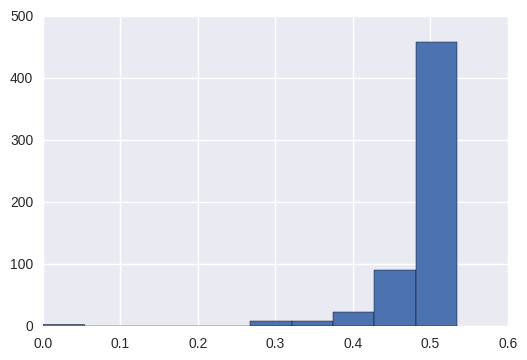

In [236]:
test_comments.groupby('from_id').agg(np.std)['prediction'].hist()

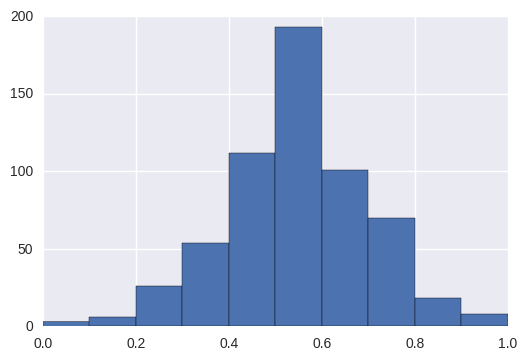

In [245]:
test_comments.groupby('from_id').agg(np.mean)['prediction'].hist()

## Char-Rnn

### Preparing data and training

In [91]:
from collections import Counter
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop, Adam
import string

In [100]:
comments_for_char = []
for l, c in zip(comments_lenghts, comments_list):
    if l > 65:
        comments_for_char.append(c)

In [101]:
comments_for_char[:5]

['имя они кагбэ намекают, что накручивают левых платежей не очень много. Суки они все.',
 'имя просто вою! Бли-и-н... А знаешь, что такое буква "У" на некоторых автомобилях :)))) (сколько же дебилов на свете,а?)',
 'имя к восстановлению твоей машины твой полис ОСАГО никакого отношения не имеет, он нужен только в том случае, когда _ты_ кого-то подобьешь. Тогда расходы несешь не ты (в каких-то пределах, разумеется), а страховщик. Это страховка ответственности, а не автомобиля.',
 'имя ды конечно же, никто не рассчитывает. Зачем еще что-то рассчитывать, беря кредит?! И как ты там сказал? "Прости господи, Поло"? Да. Верх нищеты. Последняя черта перейдена :( Соотечественники пухнут с голоду, рецепты для похудания актуальны как никогда!',
 '(бегает по дому, орет) А-а-а!!!! Мне ездить на этом, на "п"? А-а-а-а!!!!']

In [102]:
joined_text = ''
for c in comments_for_char:
    joined_text += c.lower() + '\n'

In [103]:
joined_text[:100]

'имя они кагбэ намекают, что накручивают левых платежей не очень много. суки они все.\nимя просто вою!'

### Counting chars

In [104]:
counter = Counter(joined_text)

In [105]:
len(counter.values())

464

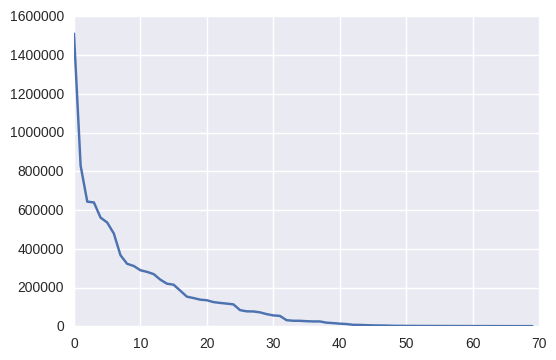

In [106]:
plt.plot(range(len(counter.values()))[:70], [x[1] for x in counter.most_common()[:70]]);

In [107]:
counter.most_common(10)

[(' ', 1510375),
 ('о', 828967),
 ('а', 643372),
 ('е', 639201),
 ('т', 561027),
 ('и', 535542),
 ('н', 478808),
 ('с', 366766),
 ('р', 322508),
 ('в', 311241)]

In [108]:
char_set = sorted([c[0] for c in counter.most_common(80) if c[0] not in string.ascii_lowercase])

In [109]:
len(char_set)

67

In [110]:
char_indices = dict((c, i) for i, c in enumerate(char_set))
indices_char = dict((c, i) for c, i in enumerate(char_set))

### Filling rare chars and to lower

In [113]:
'#' in char_set

False

In [114]:
comments_for_char_filled = []
for i, com in enumerate(comments_for_char):
    new_com = ''
    for ch in com.lower():
        if ch not in char_set:
            new_com += '#'
        else:
            new_com += ch
    comments_for_char_filled.append(new_com)

In [115]:
char_indices.update({'#': len(char_indices)})
indices_char.update({len(indices_char): '#'})

### Generating dataset

In [116]:
max_len = 60
step = 6
sentences = []
next_chars = []

In [117]:
for com in comments_for_char_filled:
    for i in range(0, len(com) - max_len, step):
        sentences.append(com[i: i + max_len])
        next_chars.append(com[i + max_len])

In [118]:
len(sentences)

874753

In [119]:
sentences[:5]

['имя они кагбэ намекают, что накручивают левых платежей не оч',
 'и кагбэ намекают, что накручивают левых платежей не очень мн',
 'э намекают, что накручивают левых платежей не очень много. с',
 'кают, что накручивают левых платежей не очень много. суки он',
 'имя просто вою! бли-и-н... а знаешь, что такое буква "у" на ']

In [120]:
next_chars[:5]

['е', 'о', 'у', 'и', 'н']

### Vectorization

#### Mb sparse?

In [121]:
X = np.zeros((len(sentences), max_len, len(char_set) + 1), dtype=np.bool) # +1 because of filled rare chars with '#'
y = np.zeros((len(sentences), len(char_set) + 1), dtype=np.bool)
X.shape, y.shape

((874753, 60, 68), (874753, 68))

In [122]:
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

### Model LSTM

In [123]:
import sys

In [124]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [125]:
model = Sequential()
model.add(LSTM(256, input_shape=(max_len, len(char_set) + 1), return_sequences=True,
               dropout_W=0.2, dropout_U=0.2))
model.add(Dropout(0.2))
model.add(LSTM(256, dropout_W=0.2, dropout_U=0.2))
model.add(Dropout(0.2))
model.add(Dense(len(char_set) + 1))
model.add(Activation('softmax'))

optimizer = Adam(lr=0.002)
model.compile(optimizer, 'categorical_crossentropy')

In [126]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_1 (LSTM)                    (None, 60, 256)       332800      lstm_input_1[0][0]               
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 60, 256)       0           lstm_1[0][0]                     
____________________________________________________________________________________________________
lstm_2 (LSTM)                    (None, 256)           525312      dropout_1[0][0]                  
____________________________________________________________________________________________________
dropout_2 (Dropout)              (None, 256)           0           lstm_2[0][0]                     
___________________________________________________________________________________________

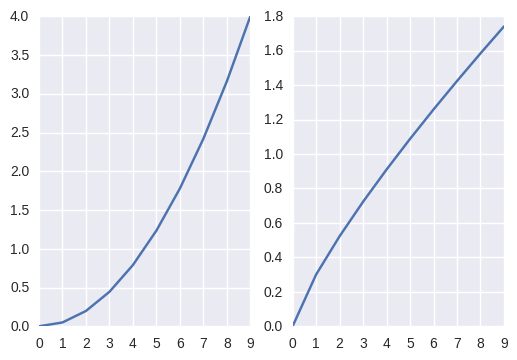

In [135]:
l = np.linspace(0, 2, 10)
ax = plt.subplot(1, 2, 1)
ax.plot(np.exp(np.log(l) / 0.5))
ax = plt.subplot(1, 2, 2)
ax.plot(np.exp(np.log(l) / 1.25))

from keras.models import model_from_json

json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("model.h5")

In [136]:
# model.load_weights("model.h5")

In [137]:
import os

In [139]:
try:
    os.remove('logs/sample.txt')
except:
    pass
try:
    os.remove('logs/score.txt')
except:
    pass

for iteration in range(1, 3):
    with open('logs/sample.txt', 'a') as f, open('logs/score.txt', 'a') as ff:
        print()
        print('-' * 50)
        print('Iteration', iteration)
        hist = model.fit(X[:300], y[:300], batch_size=256, nb_epoch=1, validation_split=0.1, shuffle=True)
        f.write('\n' + '-' * 50 + '\n')
        f.write('Iteration ' + str(iteration) + '\n')
        ff.write('Iteration ' + str(iteration) + '\n')
        f.write(str(hist.history) + '\n')
        ff.write(str(hist.history) + '\n')

        # saving
        model_json = model.to_json()
        with open("model.json", "w") as json_file:
            json_file.write(model_json)
        # serialize weights to HDF5
        model.save_weights("model.h5")

        start_index = np.random.randint(0, len(comments_for_char_filled))

        for diversity in [0.2, 0.5]:
            print()
            print('----- diversity:', diversity)
            f.write('----- diversity: ' + str(diversity) + '\n')

            generated = ''
            sentence = comments_for_char_filled[start_index]
            sentence = sentence[-max_len:]
            generated += sentence
            print('----- Generating with seed: "' + sentence + '"')
            f.write('----- Generating with seed: "' + sentence + '"\n')
            sys.stdout.write(generated)
            f.write(generated)

            for i in range(max_len):
                x = np.zeros((1, max_len, len(char_set) + 1))
                for t, char in enumerate(sentence[-max_len:]):
                    x[0, t, char_indices[char]] = 1.

                preds = model.predict(x, verbose=0)[0]
                next_index = sample(preds, diversity)
                next_char = indices_char[next_index]

                generated += next_char
                sentence = sentence[1:] + next_char

                sys.stdout.write(next_char)
                sys.stdout.flush()
                f.write(next_char)
            print()
            f.write('\n')


--------------------------------------------------
Iteration 1
Train on 270 samples, validate on 30 samples
Epoch 1/1
270/270 [==============================] - 16s - loss: 4.0292 - val_loss: 4.0006

----- diversity: 0.2
----- Generating with seed: "н = 99 кг соответственно 1 кг фазан , 4 кг кролик, 100 кабан"
н = 99 кг соответственно 1 кг фазан , 4 кг кролик, 100 кабана         а                    и    а я н .     и-7         

----- diversity: 0.5
----- Generating with seed: "н = 99 кг соответственно 1 кг фазан , 4 кг кролик, 100 кабан"
н = 99 кг соответственно 1 кг фазан , 4 кг кролик, 100 кабан ь    а а= а иниа ящ .ф  нитея,еуеьа😊36ар 😃   .0 .ки .👍   6м

--------------------------------------------------
Iteration 2
Train on 270 samples, validate on 30 samples
Epoch 1/1
270/270 [==============================] - 9s - loss: 3.9012 - val_loss: 3.8826

----- diversity: 0.2
----- Generating with seed: "глости) будет цепочка из 33х заболевших именно "меньшинств"."
глости) будет цепочк

In [125]:
def generate_with_model(model, text, diversity=0.2, len_gen=100):
    print('----- diversity:', diversity)
    
    new_text = ''
    for ch in text.lower():
        if ch not in char_set:
            new_text += '#'
        else:
            new_text += ch
            
    generated = ''
    sentence = new_text
    generated += sentence
    sentence = sentence[-max_len:]
    print('----- Generating with seed: "' + sentence + '"')
    sys.stdout.write(generated)

    # max_len = len(sentence)
    for i in range(len_gen):
        x = np.zeros((1, max_len, len(char_set) + 1))
        for t, char in enumerate(sentence[-max_len:]):
            x[0, t, char_indices[char]] = 1.

        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, diversity)
        next_char = indices_char[next_index]

        generated += next_char
        sentence = sentence[1:] + next_char

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

In [126]:
text = 'и опять на трамвайных путях. мудаки специально выбирают место аварии, чтобы парализовать целую ветку транспорта?'

In [133]:
text = 'можно для начала "мой ли сорт пива из списка избранного VS Rest"'

In [136]:
text = 'Не уверен насчёт тех 10 выражений из текста'

In [144]:
text = 'Эй, детка, да ты вся горишь, я твой огнетушитель, пыш-пыш'

In [154]:
text = 'бля сука нахуй рот твой ебал бля сука сука бля'

In [155]:
len(text)

46

In [167]:
generate_with_model(model, text, diversity=0.5)

----- diversity: 0.5
----- Generating with seed: "ка нахуй рот твой ебал бля сука сука бля"
бля сука нахуй рот твой ебал бля сука сука бля в россии - компания не приносит себя курит и уже не пострадали в очередной водителях. ну и думаю он


In [150]:
generate_with_model(model, text, diversity=0.4, len_gen=250)

----- diversity: 0.4
----- Generating with seed: "вся горишь, я твой огнетушитель, пыш-пыш"
эй, детка, да ты вся горишь, я твой огнетушитель, пыш-пышков и постоянно возможно достаточно на себе не видела, а то даже не спасает на дорогах не выходит. и то странно продаются о том, что это не спасибо он не помню как они просто не возить на площади не оставили производитель по бородовой под своими горо


### Meta model from hidden layer representation

In [ ]:
model_i = Sequential()
model_i.add(LSTM(256, input_shape=(max_len, len(char_set) + 1), weights=model.layers[0].get_weights()))
#model.add(Dense(len(char_set) + 1))
# model.add(Activation('softmax'))

optimizer = Adam(lr=0.001)
model_i.compile(optimizer, 'categorical_crossentropy')

In [ ]:
model_i.summary()

In [ ]:
pr = model_i.predict(X[:1024], batch_size=512)

In [ ]:
pr_df = pd.DataFrame(pr)

In [ ]:
import seaborn as sns

In [ ]:
sns.barplot(data=pr_df)

### Testing model

In [ ]:
comments_for_test = []
y = []
for l, c, y_ in zip(comments_lenghts, comments_list, comments.is_gum):
    if l >= 40:
        comments_for_test.append(c)
        y.append(y_)
len(comments_for_test)

In [ ]:
comments_for_test_filled = []
for i, com in enumerate(comments_for_test):
    new_com = ''
    for ch in com.lower():
        if ch not in char_set:
            new_com += '#'
        else:
            new_com += ch
    comments_for_test_filled.append(new_com)

In [ ]:
sentences_for_test = []
for com in comments_for_test_filled:
    sentences_for_test.append(com[:max_len])

In [ ]:
X = np.zeros((len(sentences_for_test), max_len, len(char_set) + 1), dtype=np.bool) # +1 because of filled rare chars with '#'
X.shape

In [ ]:
for i, sentence in enumerate(sentences_for_test):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1

In [ ]:
%time prediction = model_i.predict(X, batch_size=256)

In [ ]:
prediction.shape

### Models on embeding

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(prediction, y, test_size=0.3)

In [ ]:
rf = RandomForestClassifier(50, n_jobs=-1)

In [ ]:
cross_val_score(rf, prediction, y)

In [ ]:
lr = LogisticRegression(C=0.1)

In [ ]:
lr.fit(X_train, y_train)

In [ ]:
rf.fit(X_train, y_train)

In [ ]:
sum(p) / len(y_test)

In [ ]:
p = lr.predict(X_test)

In [ ]:
p = rf.predict(X_test)

In [ ]:
f1_score(y_test, p)

In [ ]:
accuracy_score(y_test, p)

# Clearing comments

In [ ]:
from sklearn import ensemble


In [ ]:
y = comments.is_gum.values

In [ ]:
adj_proportion = []

In [ ]:
errors = []

In [ ]:
def clear_comments(comments, with_stemmer=False, with_lemmer=True, to_lower=True, without_names=False,
                without_stop_words=False, min_word_len=None, with_emoji=False):
    global adj_proportion
    global errors 
    adj_proportion = []
    errors = []
    clear_comments = []
    stop_words = set(get_stop_words('ru'))
    stemmer = Stemmer.Stemmer('russian')
    lemmer = pymorphy2.MorphAnalyzer()
    
    names_del = 0
    i = -1
    for comment in comments:
        comment_ = comment
        i += 1
        if to_lower:
            comment = comment.lower()
        comment = re.sub('[^а-яА-ЯёЁa-zA-Z\-]', ' ', comment)
        comment = comment.split()
        if without_stop_words:
            comment = [c for c in comment if c not in stop_words]
        if with_stemmer:
            comment = stemmer.stemWords(comment)
            if without_names:
                with open('names_from_sent.txt', 'r') as f:
                    names = f.readlines()
                    names = set([name.strip() for name in names])
                before = len(comment)
                comment = [c for c in comment if c not in names]
                aft = len(comment)
                names_del += before - aft
        elif with_lemmer:
            parsed = [lemmer.parse(c)[0] for c in comment]
            comment = [p.normal_form for p in parsed]
            adj = sum([1 for p in parsed if 'ADJ' in str(p.tag)])
            if len(comment) == 0:
                errors.append(comment_)
                adj_proportion.append(0)
            else:
                adj_proportion.append(adj / len(comment))
            if without_names:
                with open('names.txt', 'r') as f:
                    names = f.readlines()
                    names = set([name.strip() for name in names])
                    before = len(comment)
                    comment = [c for c in comment if c not in names]
                    aft = len(comment)
                    names_del += before - aft
        if min_word_len is not None:
            comment = [c for c in comment if len(c) >= min_word_len]
        if with_emoji:
            comment.extend(emoji_from_comments_rep[i])
        clear_comments.append(' '.join(comment))
    print('names del: {}'.format(names_del))
    return clear_comments

### Char

In [ ]:
lr = lm.LogisticRegression()

In [ ]:
%%time
clear_coms = clear_comments(comments_list, min_word_len=2, with_emoji=False, with_stemmer=False,
                            with_lemmer=False, without_names=True, without_stop_words=False)

In [ ]:
clear_coms[10:15]

In [ ]:
%%time
vectorizer = CountVectorizer(max_features=1000, min_df=50, ngram_range=(3, 3), analyzer='char_wb')
char_features = vectorizer.fit_transform(clear_coms)

In [ ]:
np.array(vectorizer.get_feature_names())[np.random.randint(0, 1000, 50)]

In [ ]:
char_features.shape, comments.shape

In [ ]:
np.mean(cross_val_score(lr, char_features, comments.is_gum, cv=5))

### Word

In [ ]:
from sklearn import ensemble

In [ ]:
rf = ensemble.RandomForestClassifier(n_jobs=-1)

In [ ]:
%%time
clear_coms = clear_comments(comments_list, min_word_len=3, with_emoji=True, with_stemmer=False,
                            with_lemmer=True, without_names=True, without_stop_words=False)

In [ ]:
errors

In [ ]:
clear_coms[10:15]

In [ ]:
adj_proportion[10:15]

In [ ]:
%%time
vectorizer = CountVectorizer(max_features=5000, min_df=50, ngram_range=(1, 2), analyzer='word')
word_features = vectorizer.fit_transform(clear_coms)

In [ ]:
word_features.shape

In [ ]:
np.array(vectorizer.get_feature_names())[np.random.randint(0, 1000, 20)]

In [ ]:
char_features.shape, word_features.shape

In [ ]:
np.mean(cross_val_score(lr, word_features, comments.is_gum, cv=5))

In [ ]:
%%time
np.mean(cross_val_score(rf, word_features, comments.is_gum, cv=5))

## LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
np.random.seed(7)

In [ ]:
import keras.preprocessing.text
from keras.preprocessing import sequence

In [ ]:
tk = keras.preprocessing.text.Tokenizer(nb_words=2000, filters=keras.preprocessing.text.base_filter(), lower=True, split=" ")
tk.fit_on_texts(clear_coms)

In [ ]:
x = tk.texts_to_sequences(clear_coms)

In [ ]:
x = sequence.pad_sequences(x, maxlen=50, padding='pre')

In [ ]:
x[0]

In [ ]:
len(x)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, comments.is_gum, test_size=0.1, random_state=0)

### Make it balanced

In [ ]:
vc = y_train.value_counts()
vc

In [ ]:
delta = vc[1] - vc[0]
delta

In [ ]:
y_train.reset_index(drop=True, inplace=True)
index_to_add = np.random.choice(y_train[y_train == 0].index, delta, replace=False)

In [ ]:
X_train = np.append(X_train, X_train[index_to_add], axis=0)
y_train = np.append(y_train.values, [0] * delta, axis=0)

In [ ]:
X_train.shape, y_train.shape

In [ ]:
(y_train == 1).sum(), (y_train == 0).sum()

#### Shuffle

In [ ]:
index = list(range(len(y_train)))
np.random.shuffle(index)

In [ ]:
X_train = X_train[index]
y_train = y_train[index]

### Model

In [ ]:
%%time
# create the model
embedding_vector_length = 64
model = Sequential()
model.add(Embedding(2000, embedding_vector_length)) #, input_length=max_comment_length))
model.add(Dropout(0.5))
# model.add(LSTM(64, return_sequences=False, dropout_W=0.3, dropout_U=0.3))  # returns a sequence of vectors of dimension 32
model.add(GRU(64, return_sequences=False, dropout_W=0.3, dropout_U=0.3))  # returns a sequence of vectors of dimension 32
# model.add(LSTM(64, return_sequences=True))  # returns a sequence of vectors of dimension 32
model.add(Dropout(0.3))
# model.add(LSTM(64))  # return a single vector of dimension 32
# model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=5, batch_size=4096)

In [ ]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
vects.shape[1]

In [ ]:
%%time
# create the model
embedding_vector_length = 128
model = Sequential()
model.add(LSTM(128, return_sequences=False, input_shape=(43, 500)))  # returns a sequence of vectors of dimension 32
# model.add(LSTM(64, return_sequences=True))  # returns a sequence of vectors of dimension 32
# model.add(Dropout(0.2))
# model.add(LSTM(64))  # return a single vector of dimension 32
# model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(np.zeros(vects, np.zeros(1000)))

## Models

In [ ]:
from sklearn import naive_bayes, neighbors, ensemble

In [ ]:
lr = naive_bayes.MultinomialNB()

In [ ]:
lr = ensemble.RandomForestClassifier(10, min_samples_leaf=3, max_features=0.8, n_jobs=-1)

In [ ]:
lr = ensemble.GradientBoostingClassifier()

In [ ]:
lr = lm.LogisticRegression()

In [ ]:
np.random.seed(0)

In [ ]:
%%time
baseline_scores = cross_val_score(lr, word_features, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

In [ ]:
%%time
baseline_scores = cross_val_score(lr, char_features, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

In [ ]:
from scipy import sparse

In [ ]:
word_char_features = sparse.hstack((word_features, char_features))

In [ ]:
word_char_features.shape

In [ ]:
%%time
baseline_scores = cross_val_score(lr, word_char_features, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

In [ ]:
%%time
lr.fit(X, y)

In [ ]:
lr.score(X, y)

In [ ]:
lr.feature_importances_.argsort()[-10:]

In [ ]:
lr.coef_.argmax()

In [ ]:
vectorizer.get_feature_names()[648]

In [ ]:
for w in lr.feature_importances_.argsort()[-100:]:
    print(vectorizer.get_feature_names()[w])

### Is the first letter of sentence upper

In [ ]:
def sentence_stat(comments):
    big_letter = []
    sents_count = []
    for comment in comments:
        sents = list(segmenter.split_single(re.sub('(\)+|\.+)', '\n', comment)))
        count = sum([1 for sent in sents if sent and (sent[0].isupper() or 'adddresssation' in sent
                                                      or (len(sent) > 1 and sent[0] == '"' and sent[1].isupper()))])
        total = sum([1 for sent in sents if sent.strip() != ''
                     and re.match('.*[a-zа-яё].*', sent.strip(), flags=re.IGNORECASE)])
        # print(count, total)
        if total:
            big_letter.append(count // total)
        else:
            big_letter.append(1)
        sents_count.append(total)
    return big_letter, sents_count

In [ ]:
print(re.match('.*[a-zа-яё].*', '', flags=re.IGNORECASE))

In [ ]:
sentence_stat(comments_list[250:260])

In [ ]:
comments_list[355:360]

In [ ]:
[list(segmenter.split_single(re.sub('(\)+|\.+)', '\n', c))) for c in comments_list[350:360]]

In [ ]:
%%time
big_letter, sents_count = sentence_stat(comments_list)
big_letter = np.reshape(big_letter, (-1, 1))
sents_count = np.reshape(sents_count, (-1, 1))

In [ ]:
sents_count[350:360]

In [ ]:
pd.Series(big_letter.ravel()).value_counts()

In [ ]:
baseline_scores = cross_val_score(lr, sents_count, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

In [ ]:
comments['all_sent_upper'] = letters

In [ ]:
sns.countplot(x='all_sent_upper', hue='is_gum', data=comments)

### Punctuation count in comment

In [ ]:
def punctuation_counts(comments, pattern='\(+', partion=True):
    if partion:
        return [sum(len(p) for p in re.findall(pattern, c)) / len(c) * 100 for c in comments]
    else:
        return [1 if len(re.findall(pattern, c)) > 0 else 0 for c in comments]

In [ ]:
comments_list[:10]

In [ ]:
commas = punctuation_counts(comments_list, pattern='[\.]{2,}', partion=True)

In [ ]:
punctuation_counts(['he... w...'], pattern='[\.]{2,}', partion=True)

In [ ]:
commas[:10]

In [ ]:
pd.Series(commas).value_counts()

In [ ]:
commas = np.reshape(commas, (-1, 1))

In [ ]:
lr = lm.LogisticRegression()

In [ ]:
lr = ensemble.RandomForestClassifier(10)

In [ ]:
baseline_scores = cross_val_score(lr, commas, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

In [ ]:
comments['commas'] = commas

In [ ]:
sns.countplot(x='commas', hue='is_gum', data=comments)

### Mean word length

In [ ]:
def mean_word_length(comments):
    lengths = []
    for comment in comments:
        comment = comment.lower()
        comment = re.sub('[^а-яё\-]', ' ', comment).split()
        ls = [len(w) for w in comment]
        if len(ls):
            lengths.append(sum(ls) / len(ls))
        else:
            lengths.append(1)
    return lengths

In [ ]:
comments_list[35:40]

In [ ]:
mean_length = mean_word_length(comments_list)
mean_length[35:40]

In [ ]:
mean_length = np.reshape(mean_length, (-1, 1))

In [ ]:
baseline_scores = cross_val_score(lr, mean_length, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

### Caps WORD

In [ ]:
def caps_words(comments, partion=True):
    caps = []
    for comment in comments:
        count = len(re.findall('[А-ЯЁA-Z\-]{4,}', comment))
        total = len(comment.split())
        if partion and total != 0:
            caps.append(count / total * 100)
        else:
            caps.append(1 if count > 0 else 0)
    return caps

In [ ]:
caps = caps_words(comments_list, False)

In [ ]:
comments_list[:10]

In [ ]:
caps[:10]

In [ ]:
pd.Series(caps).value_counts()

In [ ]:
caps = np.reshape(caps, (-1, 1))

In [ ]:
baseline_scores = cross_val_score(lr, caps, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

### English words

In [ ]:
def eng_words(comments, partion=True):
    engs = []
    for comment in comments:
        count = len([w for w in re.findall('[a-z\-]{3,}', comment, flags=re.IGNORECASE) if w != 'adddresssation'])
        total = len(comment.split())
        if partion and total != 0:
            engs.append(count / total * 100)
        else:
            engs.append(1 if count > 0 else 0)
    return engs

In [ ]:
engs = eng_words(comments_list, False)

In [ ]:
pd.Series(engs).value_counts()

In [ ]:
engs = np.reshape(engs, (-1, 1))

In [ ]:
lr = lm.LogisticRegression()

In [ ]:
baseline_scores = cross_val_score(lr, engs, y, cv=10)
print(baseline_scores.mean(), baseline_scores.stdt())

### All comments features together

In [ ]:
def get_comments_features(coms):
    features = pd.DataFrame()
    features['with_emoji'] = with_emoji(coms)
    big_letter, sents_count = sentence_stat(coms)
    features['big_letter'] = big_letter
    features['sents_count'] = sents_count
    features['punct_)'] = punctuation_counts(coms, pattern='\)+')
    features['punct_('] = punctuation_counts(coms, pattern='\)+', partion=False)
    features['punct_...'] = punctuation_counts(coms, pattern='\.\.\.', partion=False)
    features['punct_?'] = punctuation_counts(coms, pattern='\?+')
    features['punct_!'] = punctuation_counts(coms, pattern='\!+')
    features['punct_..'] = punctuation_counts(coms, pattern='[\.]{2,}')
    features['punct_1-9'] = punctuation_counts(coms, pattern='[0-9]{1,}')
    features['punct_"'] = punctuation_counts(coms, pattern='".+"')
    features['eng_words'] = eng_words(coms, True)
    features['mean_word_len'] = mean_word_length(coms)
    features['caps'] = caps_words(coms, True)
    features['em_proportion_rep'] = comments['em_proportion_rep'].values
    features['em_proportion_no_rep'] = comments['em_proportion_no_rep'].values
    features['adj_proportion'] = adj_proportion
    features['abc_proportion'] = comments['abc_proportion'].values
    return features

In [ ]:
comment_features = get_comments_features(comments_list)

In [ ]:
comment_features.describe()

## word2vec

In [ ]:
model_web = word2vec.Word2Vec.load_word2vec_format('../RussianHorrorStories/models_bin/web.model.bin', binary=True)

In [ ]:
def get_vector_from_words(words, model, num_features):
    features = np.zeros((num_features,), dtype=np.float32)
    n = 0
    index2word = set(model.index2word)
    
    for word in words:
        if word in index2word:
            features += model[word]
            n += 1
    return features / n

In [ ]:
model_web.similar_by_vector(np.zeros(500))

In [ ]:
model_web.similar_by_vector(np.array([0.00001] * 500))

In [ ]:
def get_texts_vectors_long(texts, model, num_features=500):
    max_len = max([len(w.split()) for w in texts])
    texts_vectors = np.zeros((len(texts), max_len, num_features), dtype=np.float32)
    index2word = set(model.index2word)
    i = 0
    for text in texts:
        words = text.split()
        features = np.zeros((max_len, num_features), dtype=np.float32)
        for j in range(max_len):
            if j < len(words):
                word = words[j]
                if word in index2word:
                    features[j] = model[word]
                else:
                    features[j] = [0.1] * num_features
            else:
                features[j] = [0] * num_features
        texts_vectors[i] = features
        i += 1
    return texts_vectors

In [ ]:
def get_texts_vectors(texts, model, num_features):
    texts_vectors = np.zeros((len(texts), num_features), dtype=np.float32)
    
    i = 0
    for text in texts:
        texts_vectors[i] = get_vector_from_words(text.split(), model, num_features)
        i += 1
    return texts_vectors

In [ ]:
for i in range(len(model_web.index2word)):
    model_web.index2word[i] = re.split('_', model_web.index2word[i])[0]
model_web.vocab = {re.split('_', x[0])[0]: x[1] for x in list(model_web.vocab.items())}

In [ ]:
clear_coms[30:35]

In [ ]:
%%time
vects = get_texts_vectors_long(clear_coms[:1000], model_web, 500)

In [ ]:
%%time
vects = get_texts_vectors(clear_coms, model_web, 500)

In [ ]:
for vec in vects[30:35]:
    print(model_web.similar_by_vector(vec, 5))

In [ ]:
index_to_del = comments[(np.isnan(vects).sum(axis=1) != 0)].index

In [ ]:
index_to_del.shape

In [ ]:
comments.drop(index_to_del, inplace=True)
comments_list = comments_list[np.isnan(vects).sum(axis=1) == 0]
vects = vects[np.isnan(vects).sum(axis=1) == 0]

In [ ]:
y = comments.is_gum.values

In [ ]:
lr = lm.LogisticRegression()

In [ ]:
len(y), len(vects)

In [ ]:
%%time
baseline_scores = cross_val_score(lr, vects, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

## LDA

## Filtering dictionary

In [ ]:
import copy

In [ ]:
splited_coms = [com.split() for com in clear_coms]
dictionary = corpora.Dictionary(splited_coms)
corpus = [dictionary.doc2bow(com) for com in splited_coms]
print(dictionary.filter_extremes())

In [ ]:
dictionary_filtered = copy.deepcopy(dictionary)
dictionary_filtered.filter_extremes(no_below=10, no_above=0.5)

In [ ]:
with open('names_from_sent.txt', 'r') as f:
    names = f.readlines()
    names = [name.strip() for name in names]
names_ids = []
for name in names:
    try:
        names_ids.append(dictionary_filtered.token2id[name])
    except:
        pass
dictionary_filtered.filter_tokens(bad_ids=names_ids)

In [ ]:
print(dictionary_filtered)

In [ ]:
dict_count_before= len(dictionary)
corpus_size_before = sum([word[1] for document in corpus for word in document])
corpus = [dictionary_filtered.doc2bow(text) for text in splited_coms]
dict_count_after = len(dictionary_filtered)
corpus_size_after = sum([word[1] for document in corpus for word in document])

In [ ]:
print('Dictionary size\nBefore: {}; after: {}\nCorpus size\nBefore: {}; after: {}'.format(
      dict_count_before, dict_count_after, corpus_size_before, corpus_size_after))

In [ ]:
dictionary_filtered.save('models_bin/dictionary_filtered')

### Model

If already trained before

In [ ]:
%%time
dictionary_filtered = corpora.Dictionary.load('models_bin/dictionary_filtered')
splited_texts = [text.split() for text in stemmed_posts_texts]
corpus = [dictionary_filtered.doc2bow(text) for text in splited_texts]

In [ ]:
%%time
ldamodel = models.LdaModel(corpus, id2word=dictionary_filtered, num_topics=30, passes=50)
                           # alpha='auto') #, eta='auto')

In [ ]:
ldamodel.save('models_bin/lda')

In [ ]:
ldamodel = models.LdaModel.load('models_bin/lda')

In [ ]:
for i, topic in ldamodel.show_topics(num_topics=30, num_words=5, formatted=False):
    print("Topic " + str(i) + ': ')
    for word, p in topic:
        print(word, p)

In [ ]:
clear_coms[100]

In [ ]:
ldamodel.get_document_topics(list(corpus)[100], minimum_probability=0.05)

In [ ]:
topic = ldamodel.show_topic(3, 10)
for word, p in topic:
    print(word, p)

In [ ]:
perplexity = ldamodel.log_perplexity(list(corpus))
print(2**(-perplexity))

In [ ]:
perplexity = ldamodel.log_perplexity(list(corpus))
print(2**(-perplexity))

## Getting LDA Feature matrix

In [ ]:
splited_train_texts = [text.split() for text in x_train]
corpus_train_dataset = [dictionary_filtered.doc2bow(text) for text in splited_train_texts]

In [ ]:
def get_corpus_matrix(model, corpus):
    matrix = np.zeros((len(corpus), model.num_topics))
    for i in range(len(corpus)):
        doc_topics = model.get_document_topics(list(corpus)[i], minimum_probability=0.05)
        for topic_id, prob in doc_topics:
            matrix[i, topic_id] = prob
    return matrix

In [ ]:
%%time
X_lda = get_corpus_matrix(ldamodel, corpus)

In [ ]:
X_lda.shape

In [ ]:
comments.shape

In [ ]:
lr = lm.LogisticRegression()

In [ ]:
%%time
baseline_scores = cross_val_score(lr, X_lda, comments.is_gum, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

## Final model

In [ ]:
word_char_features.shape, comment_features.shape # meta_features.shape

In [ ]:
X = np.hstack((word_char_features.toarray(), comment_features.values))

In [ ]:
X.shape

In [ ]:
y = comments.is_gum.values

In [ ]:
lr = lm.LogisticRegression()

In [ ]:
lr = naive_bayes.MultinomialNB()

In [ ]:
lr = ensemble.RandomForestClassifier(20, min_samples_leaf=3, max_features=0.8, n_jobs=-1)

In [ ]:
lr = ensemble.GradientBoostingClassifier()

In [ ]:
np.random.seed(0)

In [ ]:
baseline_scores = cross_val_score(lr, X, y, cv=3)
print(baseline_scores.mean(), baseline_scores.std())

## Testing on human

In [ ]:
from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

In [ ]:
s = StratifiedShuffleSplit(y, n_iter=1, test_size=20, random_state=0)

In [ ]:
index_test = []

In [ ]:
for train, test in s:
    index_test = test
    X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]

In [ ]:
lr.fit(X_train, y_train)

In [ ]:
prediction = lr.predict_proba(X_test)[:, 1]

In [ ]:
accuracy_score(y_test, prediction)

In [ ]:
ans = []
for comment in comments_list[index_test]:
    a = input(comment)
    ans.append(int(a))

In [ ]:
sum(ans)

In [ ]:
len(ans)

In [ ]:
accuracy_score(y_test, ans)

In [ ]:
y_test = [int(y) for y in y_test]
prediction = [int(p) for p in prediction]

In [ ]:
list(zip(comments_list[index_test], y_test, prediction, ans))

In [ ]:
\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\]]]]]]